# Customer Segmentation and Market  Basket Analysis

__Introduction__:
This notebook we are using public dataset On-line Retail to explore customer segmentation. Then we go further and apply association rule mining approach to find rules and patterns in this transaction database. These customer segmentation, rules and patterns can be used to make intsightful and useful decisions as far as users' and retailers' interest is concerned. 



In [1]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

%matplotlib inline

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from mpl_toolkits.mplot3d import Axes3D

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# import Orange
# from Orange.data import Domain, DiscreteVariable, ContinuousVariable
# from orangecontrib.associate.fpgrowth import *

## Load Dataset

In [2]:
cs_df = pd.read_csv('../data/cleaned_online_retail.csv')

In [3]:
cs_df['invoicedate'] = pd.to_datetime(cs_df['invoicedate'])
cs_df = cs_df[cs_df['cancel']==False]

In [4]:
cs_df.dtypes

Unnamed: 0              int64
invoiceno              object
stockcode              object
description            object
quantity                int64
invoicedate    datetime64[ns]
unitprice             float64
customerid              int64
country                object
cancel                   bool
amount                float64
dtype: object

## Customer Segmentation:
Customer segmentation is similarly the process of dividing an organization’s customer bases into different sections or segments based on various customer attributes.  The process of customer segmentation is based on the premise of finding differences among the customers’ behavior and patterns.

The major objectives and benefits behind the motivation for customer segmentation are:
* **Higher Revenue**
* **Customer Understanding**
* **Target Marketing**
* **Finding Latent Customer Segments**


 
### RFM Model for Customer Value:

Since our dataset is limited to the sales records, and didn´t include another information about our customers, we will use a **RFM**,***Recency, Frequency and Monetary Value**, based model of customer value for finding our customer segments.
 The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:
- **Recency**: The value of how recently a customer purchased at the establishment
- **Frequency**: How frequent the customer’s transactions are at the establishment
- **Monetary value**: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment



In [5]:
refrence_date = cs_df.invoicedate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
cs_df['days_since_last_purchase'] = (refrence_date - cs_df.invoicedate).astype('timedelta64[D]')
customer_history_df =  cs_df[['customerid', 'days_since_last_purchase']].groupby("customerid").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
customer_history_df.describe().transpose()

Reference Date: 2011-12-10 12:50:00


count          mean          std      min       25%      50%  \
customerid  4338.0  15300.408022  1721.808492  12346.0  13813.25  15299.5   
recency     4338.0     92.536422   100.014169      1.0     18.00     51.0   

                 75%      max  
customerid  16778.75  18287.0  
recency       142.00    374.0

We will plot the Recency Distribution and QQ-plot to identify substantive departures from normality, likes outliers, skewness and kurtosis.

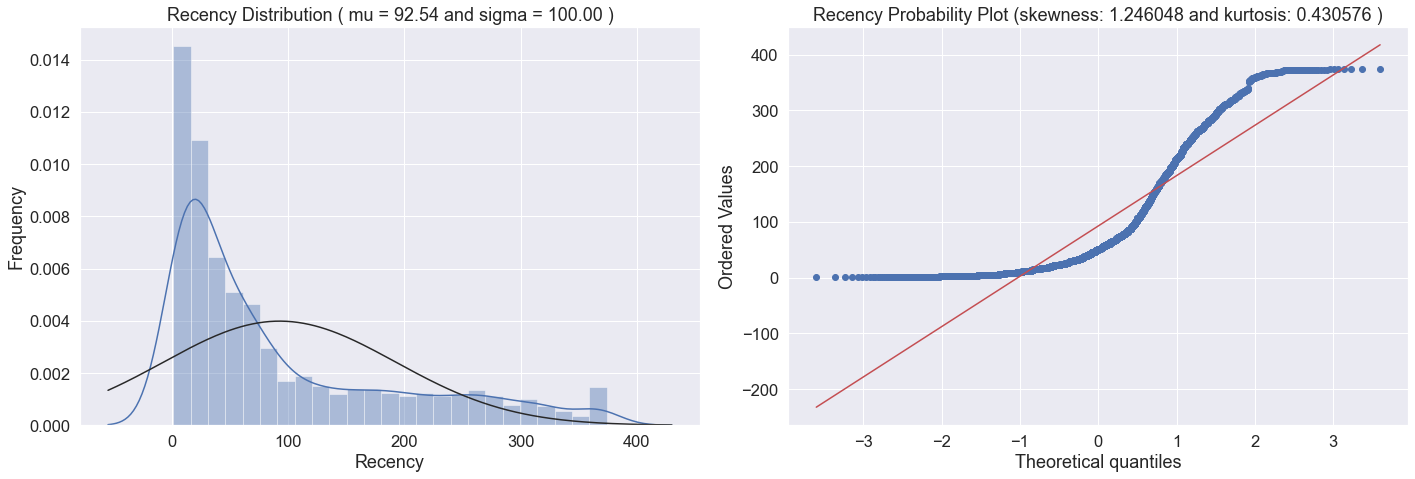

In [6]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(customer_history_df.recency, 'Recency')

With ***positive skewness***, we confirm the **lack of symmetry** and indicate that sales recency  are **skewed right**.

#### Frequency

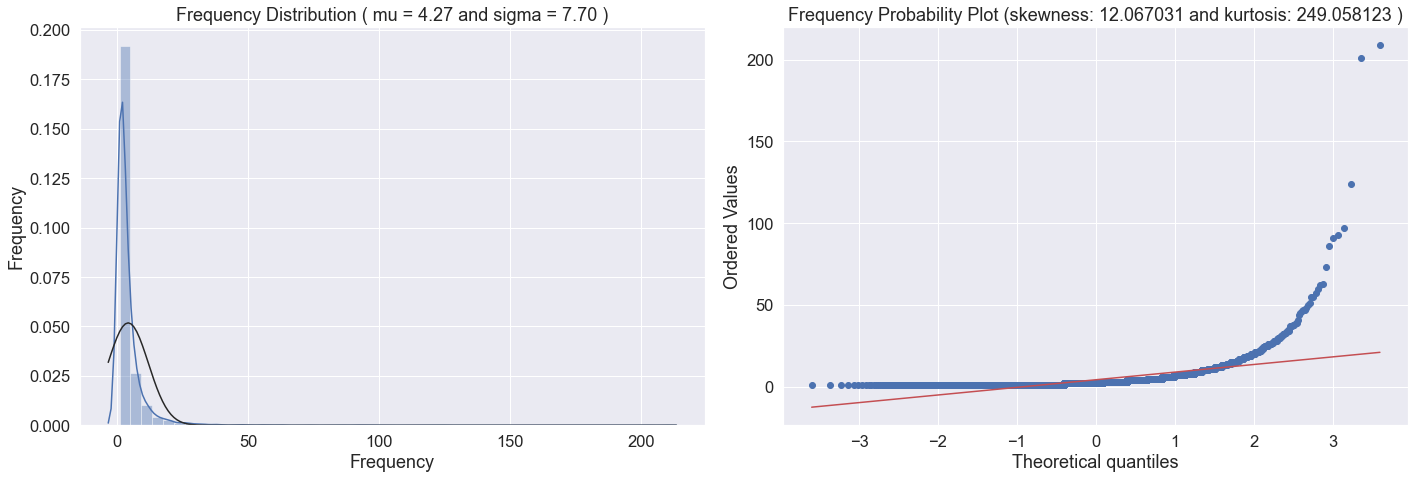

In [7]:
customer_freq = (cs_df[['customerid', 'invoiceno']].groupby(["customerid", 'invoiceno']).count().reset_index()).\
                groupby(["customerid"]).count().reset_index()
customer_freq.rename(columns={'invoiceno':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
QQ_plot(customer_history_df.frequency, 'Frequency')

With **positive skewness**, we confirm the **high lack of symmetry** and with **Kurtosis** indicates that is a **heavy-tailed distribution** and has **outliers**.

#### Monetary Value

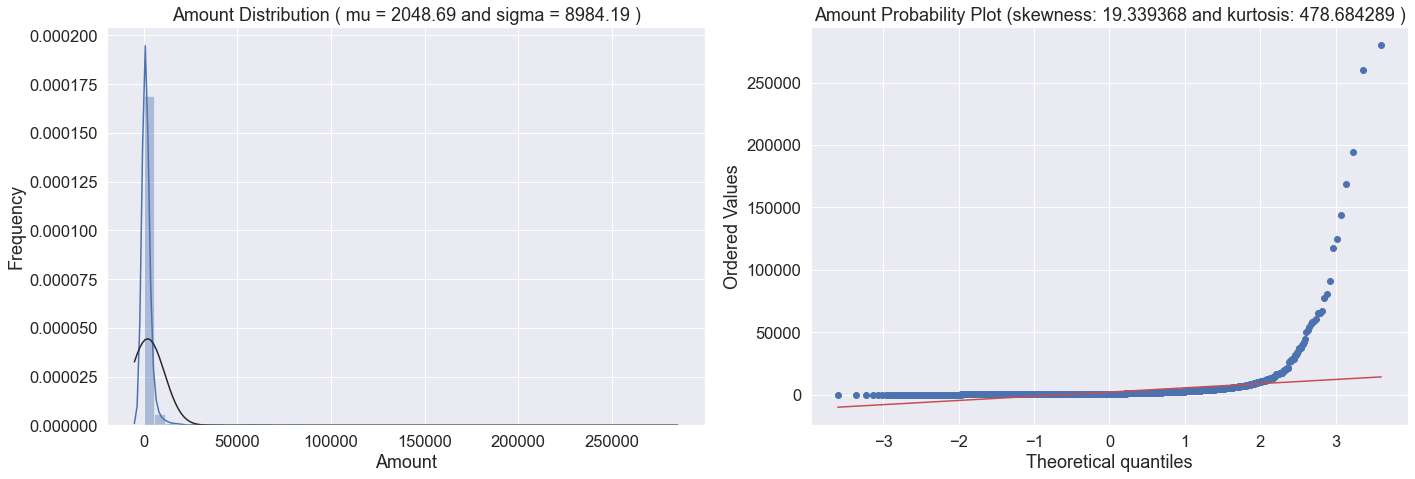

In [8]:
customer_monetary_val = cs_df[['customerid', 'amount']].groupby("customerid").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)
QQ_plot(customer_history_df.amount, 'Amount')



With ***positive skewness***, we confirm the **high lack of symmetry** and with **Kurtosis** indicates that is a **too heavy-tailed distribution** and has **outliers**.

Let's see a statistical summary of this dataset:

In [9]:
customer_history_df.describe()

customerid      recency    frequency         amount
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2048.688081
std     1721.808492   100.014169     7.697998    8985.230220
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     306.482500
50%    15299.500000    51.000000     2.000000     668.570000
75%    16778.750000   142.000000     5.000000    1660.597500
max    18287.000000   374.000000   209.000000  280206.020000

### Data Preprocessing


In [10]:
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)
feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector] #.as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

count          mean       std       min       25%       50%  \
amount_log     4338.0  1.181627e-16  1.000115 -4.172381 -0.682096 -0.063857   
recency_log    4338.0 -1.027980e-16  1.000115 -2.630445 -0.612424  0.114707   
frequency_log  4338.0 -2.355833e-16  1.000115 -1.048610 -1.048610 -0.279044   

                    75%       max  
amount_log     0.657274  4.722173  
recency_log    0.829652  1.505796  
frequency_log  0.738267  4.882714

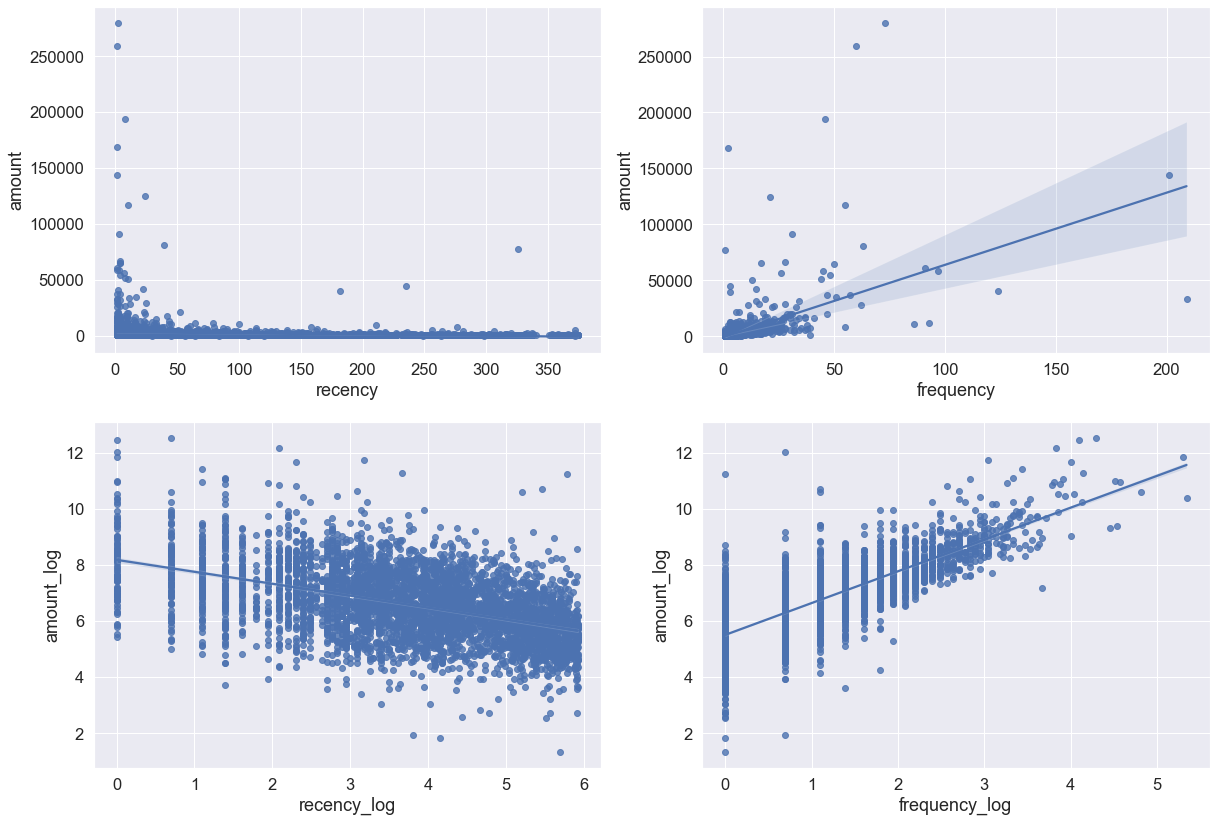

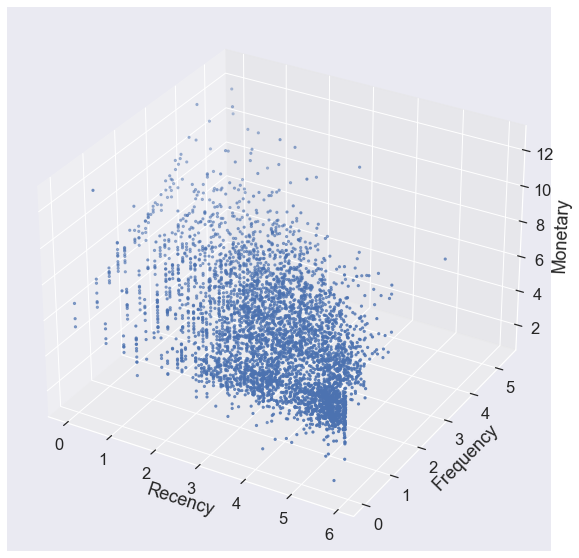

In [11]:
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='amount_log', data=customer_history_df)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='amount_log', data=customer_history_df)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

The obvious patterns we can see from the plots above is that costumers who buy with a higher frequency and more recency tend to spend more based on the increasing trend in Monetary (amount value) with a corresponding increasing and decreasing trend for Frequency and Recency, respectively. 

### Clustering for Segments


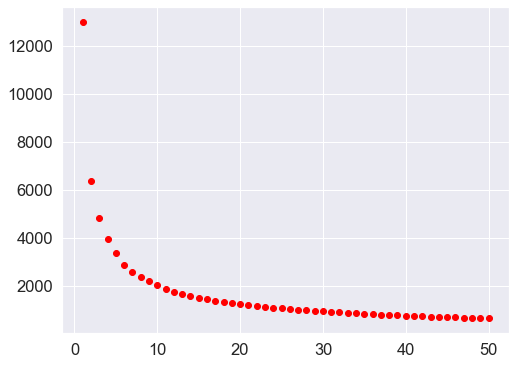

The best K sugest:  7


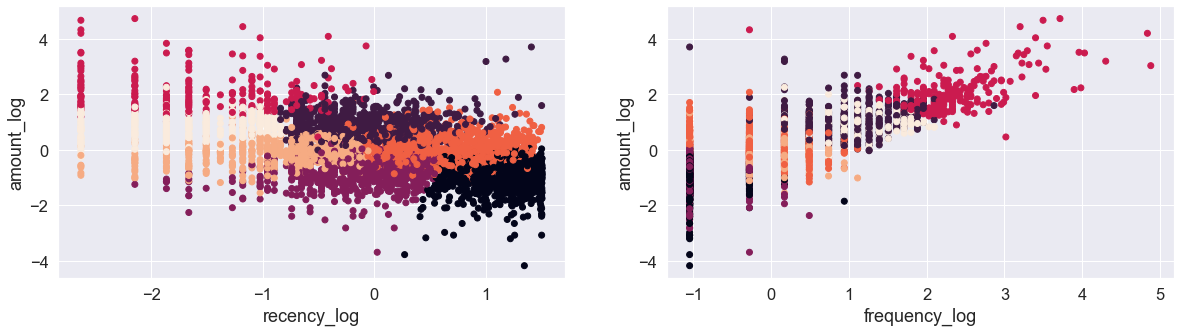

In [12]:
cl = 50
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()

# Create a kmeans model with the best K.
print('The best K sugest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])

plt.show()

Note that by the Elbow method from a K equal to 3 we already observed low rates of gain in the decay of the distortions with the decrease of K reaching the limit of 10% with the K equal to 7. With this in mind, we will begin to evaluate the options more deeply with 3, and 7, starting with the silhouette analysis.

#### Silhouette analysis on K-Means clustering



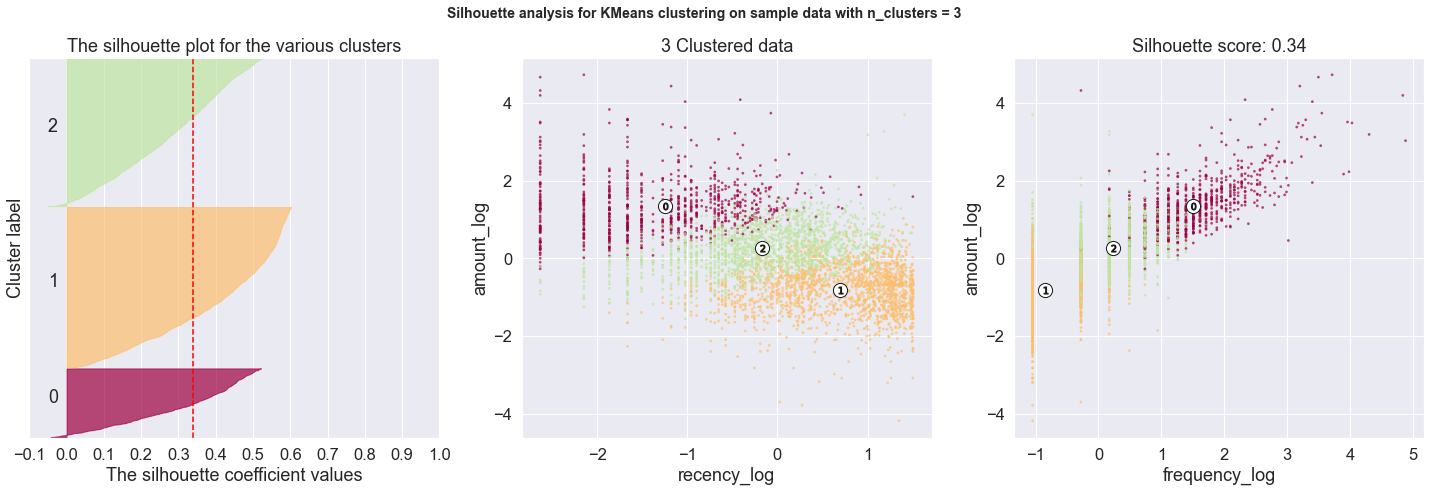

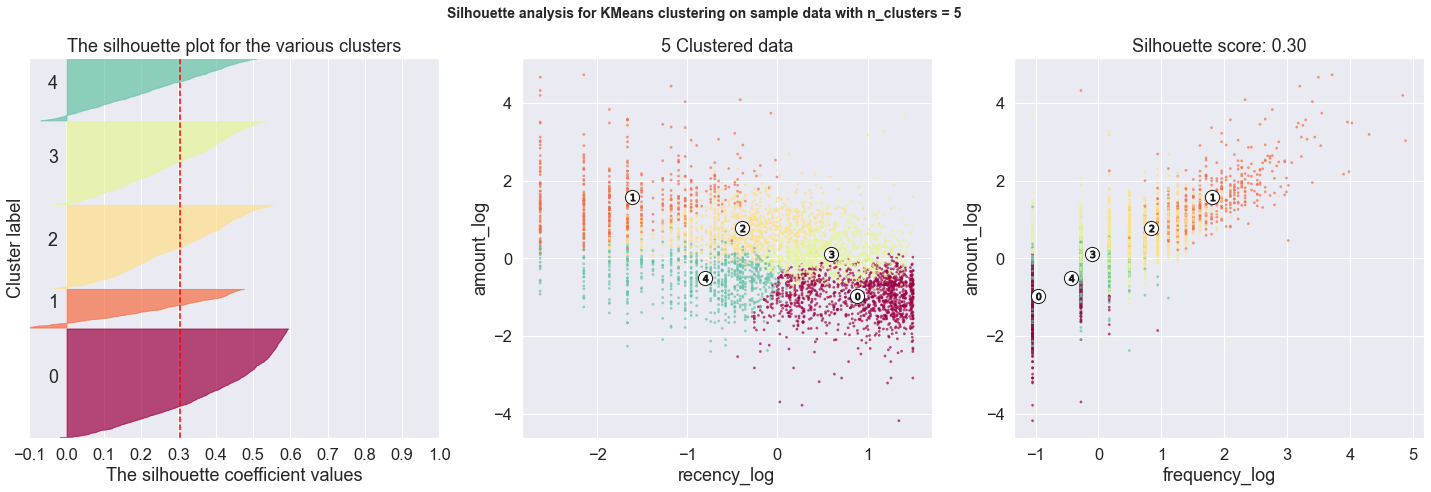

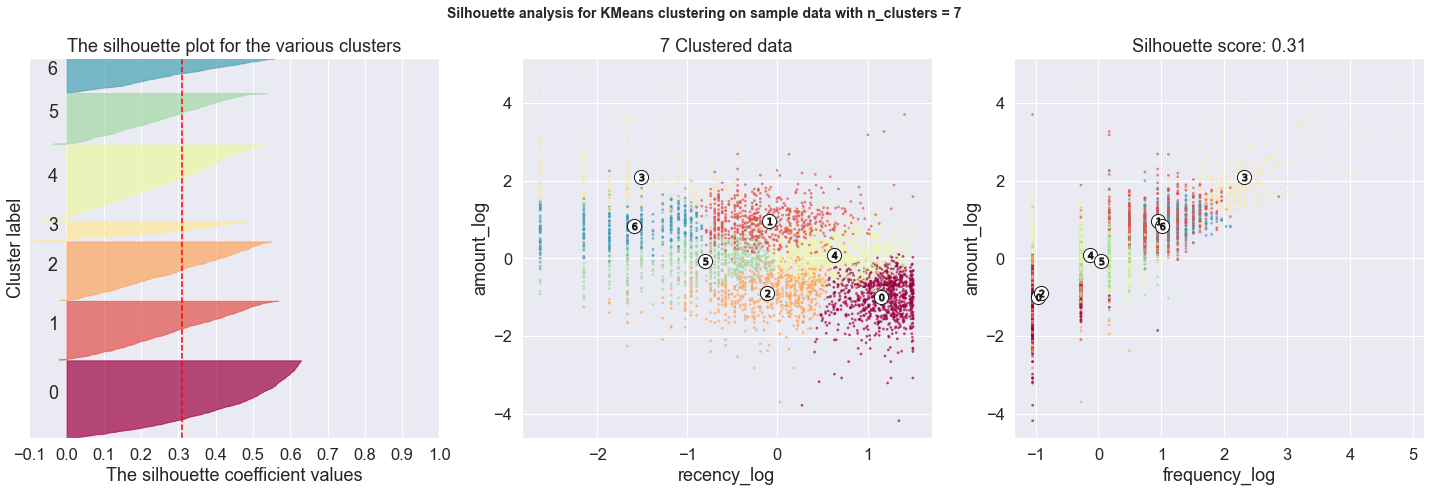

In [13]:
cluster_centers = dict()

for n_clusters in range(3,K_best+1,2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

When we look at the results of the clustering process, we can infer some interesting insights:

- First notice that all K clusters options is valid, because they don't have presence of clusters with below average silhouette scores. 
- All options had a some wide fluctuations in the size of the silhouette plots. 


#### Clusters Center:
Let's look at the cluster center values after returning them to normal values from the log and scaled version. 

In [14]:
features = ['amount',  'recency',  'frequency']
for i in range(3,K_best+1,2):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.34
Centers of each cluster:
        amount     recency  frequency
0  3928.956555    7.218684   9.997198
1   260.222876  116.191967   1.189203
2  1001.720068   34.138812   3.153595
--------------------------------------------------
for 5 clusters the silhouette score is 0.30
Centers of each cluster:
        amount     recency  frequency
0   211.549673  153.935498   1.084346
1  5330.428536    4.287685  13.077065
2  1959.126040   24.531810   5.433186
3   841.506177  101.012447   2.356421
4   389.672044   13.720296   1.743406
--------------------------------------------------
for 7 clusters the silhouette score is 0.31
Centers of each cluster:
         amount     recency  frequency
0    204.950848  225.600151   1.086187
1   2407.089421   37.803327   6.014123
2    237.781336   36.430512   1.132543
3  10156.379437    4.961015  20.687947
4    813.566173  107.106890   2.280821
5    661.120470   13.733298   2.660937
6   2100.809288    4.425310   6.403276

#### Clusters Insights:

With the plots and the center in the correct units, let's see some insights by each clusters groups:

***In the three-cluster:***
- The three clusters appears have a good stark differences in the Monetary value of the customer, we will confirm this by a box plot.
- Cluster 1 is the cluster of high value customer who shops frequently and is certainly an important segment for each business.
- In the similar way we obtain customer groups with low and medium spends in clusters with labels 0 and 2, respectively.
- Frequency and Recency correlate perfectly to the Monetary value based on the trend (High Monetary-Low Recency-High Frequency).

***In the five-cluster:***
- Note that clusters 0 and 1 are very similar to their cluster in the configuration with only 3 clusters.
- The cluster 1 appears more robust on the affirmation of those who shop often and with high amount.
- The cluster 2 are those who have a decent spend but are not as frequent as the cluster 1
- The cluster 4 purchases medium amounts, with a relatively low frequency and not very recent
- The cluster 3 makes low-cost purchases, with a relatively low frequency, but above 1, and made their last purchase more recently. This group of customers probably response to price discounts and can be subject to loyalty promotions to try increase the medium-ticket, strategy that can be better defined when we analyzing the market basket. 
- The silhouette score matrix says that the  five cluster segments are less optimal then the three cluster segments. 

***In the five-cluster:***
- Definitely cluster 6 defines those who shop often and with high amount.
- Clusters 1 and 5 show good spending and good frequency, only deferring in how recent were their last purchases, where 5 is older, which suggests an active action to sell to group 5 as soon as possible and another to 1 seeking to raise its frequency.
- Cluster 0 presents the fourth best purchase and a reasonable frequency, but this is a long time without buying. This group should be sensible to promotions and activations, so that they do not get lost and make their next purchase.
- Cluster 5 is similar to 0, but has made its purchases more recently and has a slightly better periodicity. Then actions must be taken to raise their frequency and reduce the chances of them migrating to cluster 0 by staying longer without purchasing products.

#### Drill Down Clusters:


customerid  recency  frequency    amount  recency_log  frequency_log  \
0       12346    326.0          1  77183.60     5.786897       0.000000   
1       12347      2.0          7   4310.00     0.693147       1.945910   
2       12348     75.0          4   1797.24     4.317488       1.386294   
3       12349     19.0          1   1757.55     2.944439       0.000000   
4       12350    310.0          1    334.40     5.736572       0.000000   

   amount_log  clusters_3  clusters_5  clusters_7  
0   11.253942           2           3           1  
1    8.368693           0           1           6  
2    7.494007           2           2           1  
3    7.471676           2           4           5  
4    5.812338           1           0           0

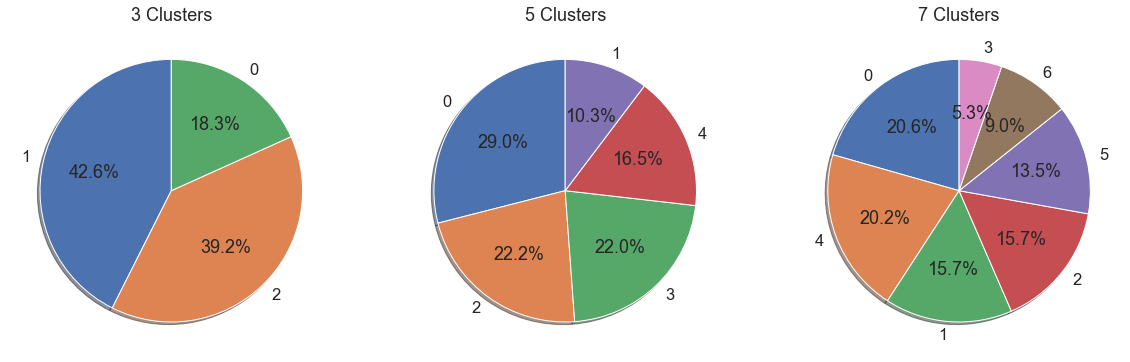

In [15]:
customer_history_df['clusters_3'] = cluster_centers[3]['labels'] 
customer_history_df['clusters_5'] = cluster_centers[5]['labels']
customer_history_df['clusters_7'] = cluster_centers[7]['labels']
display(customer_history_df.head())

fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
market = customer_history_df.clusters_3.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')
f1 = fig.add_subplot(132)
market = customer_history_df.clusters_5.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('5 Clusters')
f1 = fig.add_subplot(133)
market = customer_history_df.clusters_7.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('7 Clusters')
plt.show()

In [16]:
x_data = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 
          'rgba(22, 80, 57, 0.5)', 'rgba(127, 65, 14, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
cutoff_quantile = 95

for n_clusters in range(3,K_best+1,2):
    cl = 'clusters_' + str(n_clusters)
    for fild in range(0, 3):
        field_to_plot = features[fild]        
        y_data = list()
        ymax = 0
        for i in np.arange(0,n_clusters):
            y0 = customer_history_df[customer_history_df[cl]==i][field_to_plot].values
            y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
            if ymax < max(y0): ymax = max(y0)
            y_data.insert(i, y0)

        traces = []

        for xd, yd, cls in zip(x_data[:n_clusters], y_data, colors[:n_clusters]):
                traces.append(go.Box(y=yd, name=xd, boxpoints=False, jitter=0.5, whiskerwidth=0.2, fillcolor=cls,
                    marker=dict( size=1, ),
                    line=dict(width=1),
                ))

        layout = go.Layout(
            title='Difference in {} with {} Clusters and {:1.2f} Score'.\
            format(field_to_plot, n_clusters, cluster_centers[n_clusters]['silhouette_score']),
            yaxis=dict( autorange=True, showgrid=True, zeroline=True,
                dtick = int(ymax/10),
                gridcolor='black', gridwidth=0.1, zerolinecolor='rgb(255, 255, 255)', zerolinewidth=2, ),
            margin=dict(l=40, r=30, b=50, t=50, ),
            paper_bgcolor='white',
            plot_bgcolor='white',
            showlegend=False
        )

        fig = go.Figure(data=traces, layout=layout)
        py.offline.iplot(fig)



## Cross Selling



### Market Basket Analysis with Association Rule-Mining


##### Apriori


##### FP Growth

#### Building Transaction Dataset



In [17]:
items = list(cs_df.description.unique())
grouped = cs_df.groupby('invoiceno')
transaction_level = grouped.aggregate(lambda x: tuple(x)).reset_index()[['invoiceno','description']]
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level.to_dict('records'):
    invoice_num = rec['invoiceno']
    items_list = rec['description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})

new = [v for k,v in temp.items()]
transaction_df = pd.DataFrame(new)

#### Pruning Dataset for frequently purchased items
We saw in the earlier on EDA how only a handful of items are responsible for bulk of our sales so we want to prune our dataset to reflect this information. 

In [18]:
def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5, 
                  start_item = None, end_item = None, TopCols = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    total_items = sum(input_df.sum().sort_values(ascending = False))
    item_count.rename(columns={item_count.columns[0]:'item_name',
                               item_count.columns[1]:'item_count'}, inplace=True)
    if TopCols: 
        input_df['total_items'] = input_df[TopCols].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[TopCols], item_count[item_count.item_name.isin(TopCols)]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items],item_count[start_item:end_item]
    else:
        item_count['item_perc'] = item_count['item_count']/total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]

We use the second option of pruning, by the Top 15th products in sales events.

In [19]:
AmoutSum = cs_df.groupby(["description"]).amount.sum().sort_values(ascending = False)
inv = cs_df[["description", "invoiceno"]].groupby(["description"]).invoiceno.unique().\
      agg(np.size).sort_values(ascending = False)

Top15ev = list(inv[:15].index)

In [20]:
output_df, item_counts = prune_dataset(input_df=transaction_df, length_trans=2,start_item = 0, end_item = 15)
print('Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): {:.2f}'.format(AmoutSum[Top15ev].sum()))
print('Number of Sales Events:', output_df.shape[0])
print('Number of Products:', output_df.shape[1])

item_counts

Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): 777096.12
Number of Sales Events: 4664
Number of Products: 15


item_name  item_count
0   WHITE HANGING HEART T-LIGHT HOLDER        1978
1             REGENCY CAKESTAND 3 TIER        1703
2              JUMBO BAG RED RETROSPOT        1600
3                        PARTY BUNTING        1379
4        ASSORTED COLOUR BIRD ORNAMENT        1375
5              LUNCH BAG RED RETROSPOT        1289
6    SET OF 3 CAKE TINS PANTRY DESIGN         1146
7                              POSTAGE        1099
8             JUMBO BAG VINTAGE DOILY         1080
9              LUNCH BAG  BLACK SKULL.        1052
10              LUNCH BAG SUKI DESIGN         1043
11                      POPCORN HOLDER        1035
12     PACK OF 72 RETROSPOT CAKE CASES        1029
13                      SPOTTY BUNTING        1009
14            LUNCH BAG VINTAGE DOILY         1006

So we find out that we have 15 items responsible for 8,73% of sales amount and close to 5% of the events result in 4.664 transactions that have those items along with other items. The next step is to convert this selected data into the required table data structure.

#### Association Rule Mining with FP Growth



In [21]:
import Orange

In [22]:
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *

In [23]:
input_assoc_rules = output_df
# Defined the data domain by specifying each variable as a DiscreteVariable having values as (0, 1)
domain_transac = Domain([DiscreteVariable.make(name=item,values=['0', '1']) \
                         for item in input_assoc_rules.columns])

# Then using this domain, we created our Table structure for our data
data_tran = Orange.data.Table.from_numpy(domain=domain_transac,  
                                         X=input_assoc_rules ,Y= None)
# # Coding our input so that the entire domain is represented as binary variables
data_tran_en, mapping = OneHot.encode(data_tran, include_class=True)

In [24]:
support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0]*support))
num_trans = input_assoc_rules.shape[0]*support
itemsets = dict(frequent_itemsets(data_tran_en, support))
print('Items Set Size:', len(itemsets))

num of required transactions =  46
Items Set Size: 663273


In [25]:
confidence = 0.7
rules_df = pd.DataFrame()
if len(itemsets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_tran, mapping)}
    
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, itemsets, N))
    
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]            
        cons = ex_rule_frm_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if not rules_df.empty:
        pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
    else:
        print("Unable to generate any rule")

Raw rules data frame of 13831 rules generated


##### Explore The Association Rule Created

Let's see what we get in the first 5 rules with highest confidence:

In [26]:
dw = pd.options.display.max_colwidth
pd.options.display.max_colwidth = 100
(rules_df[['consequent', 'antecedent', 'support','confidence','lift']].\
 groupby(['consequent', 'antecedent']).first()
                                      .reset_index()
                                      .sort_values(['confidence', 'support', 'lift'],
                                                   ascending=False)).head()

consequent  \
11  JUMBO BAG VINTAGE DOILY    
72  LUNCH BAG VINTAGE DOILY    
73  LUNCH BAG VINTAGE DOILY    
70  LUNCH BAG VINTAGE DOILY    
12  JUMBO BAG VINTAGE DOILY    

                                                                                            antecedent  \
11                          JUMBO BAG RED RETROSPOT, LUNCH BAG RED RETROSPOT, LUNCH BAG VINTAGE DOILY    
72  LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG  BLACK SKULL., LUNCH BAG SUKI DESIGN    
73                           LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG SUKI DESIGN    
70                          LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG  BLACK SKULL.   
12                           JUMBO BAG RED RETROSPOT, LUNCH BAG SUKI DESIGN , LUNCH BAG VINTAGE DOILY    

    support  confidence      lift  
11       60    0.909091  4.520256  
72       49    0.890909  4.596460  
73       48    0.888889  4.586037  
70       48    0.872727  4.502655  
12       48    0.872727  4.339446

Now, the first 5 higest support:

In [27]:
(rules_df[['consequent', 'antecedent', 'support','confidence','lift']].\
 groupby(['consequent', 'antecedent']).first()
                                      .reset_index()
                                      .sort_values(['support', 'confidence', 'lift'],
                                                   ascending=False)).head()

consequent  \
62  LUNCH BAG VINTAGE DOILY    
16  JUMBO BAG VINTAGE DOILY    
1    JUMBO BAG RED RETROSPOT   
18  JUMBO BAG VINTAGE DOILY    
63  LUNCH BAG VINTAGE DOILY    

                                                                    antecedent  \
62                           JUMBO BAG VINTAGE DOILY , LUNCH BAG RED RETROSPOT   
16                           LUNCH BAG VINTAGE DOILY , JUMBO BAG RED RETROSPOT   
1                            JUMBO BAG VINTAGE DOILY , LUNCH BAG RED RETROSPOT   
18  LUNCH BAG VINTAGE DOILY , LUNCH BAG RED RETROSPOT, JUMBO BAG RED RETROSPOT   
63  JUMBO BAG VINTAGE DOILY , LUNCH BAG RED RETROSPOT, JUMBO BAG RED RETROSPOT   

    support  confidence      lift  
62      154    0.777778  4.012783  
16      153    0.805263  4.003995  
1       132    0.709677  2.737746  
18      116    0.840580  4.179599  
63      116    0.763158  3.937354

In [28]:
rules_df.lift.apply(lambda x: 'Greater Than One' if x > 1 else 'One' \
                           if x == 0 else 'Less Than One').value_counts()

Greater Than One    13831
Name: lift, dtype: int64